In [ ]:
# team Amir Stash
kaggle : 0.84231

In [ ]:
# Для использования CatBoost следует сначала его установить
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler , OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier , CatBoostRegressor

In [ ]:
data_train = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('/content/test.csv')

In [ ]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]
num_cols_churn = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
    'Churn'       
]
categorial = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [ ]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Избавление от пробелов в TotalSpent
for j in [data_train, data_test]:
  j['TotalSpent'] = j['TotalSpent'].replace(' ' , 0)
  j['TotalSpent'] = j['TotalSpent'].astype(float)

In [ ]:
# Преобразование категориальных признаков
le = LabelEncoder()
for col in categorial:
    data_train[col] = le.fit_transform(data_train[col])
    data_test[col]  = le.transform(data_test[col])
    data_train[col] = data_train[col].astype('category')
    data_test[col]  = data_test[col].astype('category')


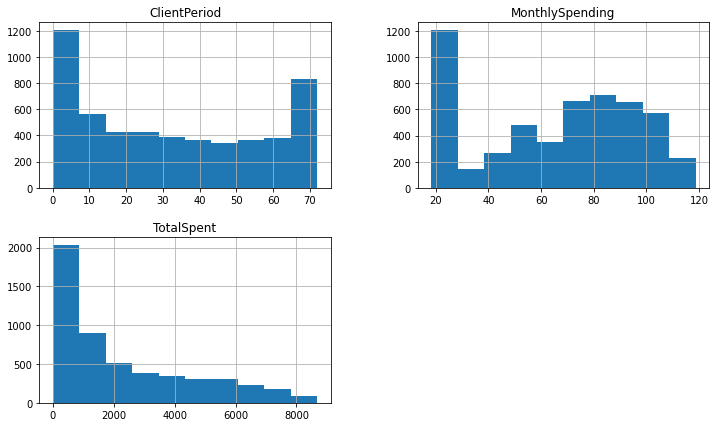

In [ ]:
data_train[num_cols_churn].hist(num_cols,figsize = (12,7));

In [ ]:
# Запись результатов в файл типа csv
def write_file(predicted_labels, out_file, target='Churn', index_label="Id"):
    predicted_data = pd.DataFrame(predicted_labels,
                                index = np.arange(len(predicted_labels)),
                                columns=[target])
    predicted_data.to_csv(out_file, index_label=index_label)

In [ ]:
# Создание фиктивных переменных
def ohe(data, numeric, categorical):
    dummy_features = pd.get_dummies(data[categorical])
    return pd.concat([data[numeric], dummy_features], axis=1)

In [ ]:
# Модель(LogisticRegression),
X = data_train.drop(columns=['Churn'])
y = data_train['Churn']

In [ ]:
X = ohe(X, num_cols, categorial)
test_ohe = ohe(data_test, num_cols, categorial)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)
model_predict = model.predict(X_test)

In [ ]:
roc_auc_score(y_test , model_predict)

0.7033509152307413

In [ ]:
 Подбор параметров через GridSearchCV
params = { 'C' : [0.001, 0.01 , 0.1 , 1 , 10]
          }
cv_model = GridSearchCV(model , param_grid= params, cv = 10 , n_jobs= -1);
cv_model.fit(X_train,y_train);

In [ ]:
model_predict = cv_model.predict(X_test)

In [ ]:
# Результаты 
roc_auc_score(y_test,model_predict)

0.7004463097034322

In [ ]:
cv_model.best_score_

0.8090302497619571

In [ ]:
cv_model.best_estimator_.fit(X,y)
prediction = cv_model.best_estimator_.predict_proba(test_ohe)
prediction

array([[0.94293041, 0.05706959],
       [0.33149669, 0.66850331],
       [0.30582657, 0.69417343],
       ...,
       [0.24756288, 0.75243712],
       [0.39982688, 0.60017312],
       [0.9840374 , 0.0159626 ]])

In [ ]:
write_file(prediction, 'prediction_LogisticRegressionCV.csv')

In [ ]:
# Использование библиотеки CatBoost

In [ ]:
params_cat = { 'iterations':[100]
          ,'l2_leaf_reg':[1,3,5,10]
          ,'learning_rate':[0.001,0.01]
          ,'depth':[3,5,7,9,10]
          ,'loss_function':['CrossEntropy']
         }

In [ ]:
model_cat = CatBoostClassifier()
model_cat_cv = GridSearchCV(estimator= model_cat , param_grid= params_cat , cv = 10 , n_jobs= -1)
model_cat_cv.fit(X_train,y_train)

In [ ]:
model_cat_cv.best_score_

0.8095700578627408

In [ ]:
# Обучаем лучшую модель
model_cat_cv.best_estimator_.fit(X,y)
prediction = model_cat_cv.best_estimator_.predict_proba(test_ohe)[:, 1]
prediction

In [ ]:
# Записываем предсказание в csv файл
write_file(prediction, 'prediction_CatBoostCV.csv')